In [1]:
import subprocess
import platform
import lmdb
import Image
import sys
import copy 
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from StringIO import StringIO
from caffe.proto import caffe_pb2
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.neighbors.kde import KernelDensity
from scipy.stats import multivariate_normal
from scipy.stats.mstats import rankdata
from sklearn.externals import joblib
from __future__ import division
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


std: 0 .5 1 2 3

In [2]:
import caffe
caffe.set_mode_gpu()
caffe.set_device(1)

print "OS:     ", platform.platform()
print "Python: ", sys.version.split("\n")[0]
print "CUDA:   ", subprocess.Popen(["nvcc","--version"], stdout=subprocess.PIPE).communicate()[0].split("\n")[3]
print "LMDB:   ", ".".join([str(i) for i in lmdb.version()])

OS:      Linux-3.13.0-65-generic-x86_64-with-Ubuntu-14.04-trusty
Python:  2.7.6 (default, Oct 26 2016, 20:30:19) 
CUDA:    Cuda compilation tools, release 7.5, V7.5.17
LMDB:    0.9.18


In [3]:
kind = 'siamese'
mid_layer = 'fc6'
next_layer = 'fc7'
addr = mid_layer+'/'+kind+'/'
print addr
num_pca = 4
repeat = 4

fc6/siamese/


In [15]:
def load_all_middle_features(net, middle_layer_name, num_batch, istest):
    # Loading all features from middle layer
    # num_batch is not the batch_size. (batch_size is set before in training)
    features = []
    labels = []
    acc = 0
    middle_layer_shape = net.blobs[middle_layer_name].data.shape
    for i in range(0, num_batch):
        out = net.forward(blobs=[middle_layer_name,'label'])
        features.append(copy.copy(np.reshape(out[middle_layer_name],(middle_layer_shape[0],-1) )))
        labels.append(copy.copy(out['label']))
        if istest==True :
            acc = acc + net.blobs['accuracy_test_top01'].data #accuracy_test_top01
    acc = acc / num_batch
    if istest==True:
        print('Accuracy of test is {:f}'.format(acc))
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    print('Features are loaded')
    print('Percentage of men is {:f}'.format(np.sum(labels)/labels.shape[0]))
    return features, labels

def my_pca(features, labels, num_pca):
    #mean_feature = np.mean(features, axis=0)
    #normalized_features = features - mean_feature
    #pca = decomposition.PCA(svd_solver='randomized')
    pca = decomposition.IncrementalPCA(batch_size=50)
    pca.n_components = num_pca
    pca.fit(features)
    print('Remained variance is:') 
    print(pca.explained_variance_ratio_) 
    X_reduced = pca.transform(features)
    print('PCA is fitted')
    if num_pca==2:
        plt.figure()
        for c, i in zip("rgbcmyk", [0, 1, 2, 3, 4, 5, 6]):
            plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], c=c)
        plt.title('PCA of features')
    return pca, X_reduced

def pirvacy_ek(X_reduced, X_reduced_noisy, noise_var):
    # Compute Privacy Measure
    # kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X_reduced_noisy)
    numdata = X_reduced.shape[0]
    d = np.array([X_reduced,]*numdata) - np.transpose(np.array([X_reduced_noisy,]*numdata),(1,0,2)) #order?
    e = multivariate_normal.pdf(d,np.zeros([X_reduced.shape[1],]), noise_var*np.eye(X_reduced.shape[1]))
    e = e.T                               # added now
    r = e/np.max(e,0)
    m = np.sum(r>.8,0)
    ranks = 1 + numdata - rankdata(r,0)
    trueranks = np.diag(ranks)
    res = np.maximum(m,trueranks)
    res = trueranks                       # watch here
    correct_rate = sum(res==1)/numdata
    print('min is {:f}      max is {:f}      mean is {:f}      std is {:f}      ratio of ranked one is {:f} '
          .format(min(res), max(res), np.mean(res), np.std(res), correct_rate))

    res = res / numdata
    priv = np.mean(res)
    print('Expected ek-privacy is {:f}'.format(priv))
    return priv, correct_rate

def compute_acc(net, middle_layer_name, next_layer_name, reconst_all_middles, reconst_all_labels, num_batch):
    newacc = 0
    print(reconst_all_middles.shape)
    for i in range(0, num_batch):
        if middle_layer_name != 'fc6':
            net.blobs[middle_layer_name].data[...] = reconst_all_middles[i,:,:,:,:]
        else:
            net.blobs[middle_layer_name].data[...] = reconst_all_middles[i,:]
        net.blobs['label'].data[...] = reconst_all_labels[i,:]
        net.forward(start=next_layer_name, end='accuracy_test_top01') #accuracy_test_top01 for gender
        newacc = newacc + net.blobs['accuracy_test_top01'].data
    newacc = newacc / num_batch
    print('Accuracy of test on reconstructed features from PCA is {:f}'.format(newacc))
    return newacc

def reduce_dim_test(pca, features, labels):
    #normalized_features = features - mean_feature
    X_reduced = pca.transform(features)
    print('extracted PCA from train data is fitted to test data')
    if pca.n_components==2:
        plt.figure()
        for c, i in zip("rgbcmyk", [0, 1, 2, 3, 4, 5, 6]):
            plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], c=c)
        plt.title('PCA of features')
    return X_reduced

In [6]:
# PCA should be done on training data

#net = caffe.Net('train/gender_train_simple.prototxt', '.simple_iter_6000.caffemodel', caffe.TRAIN) #simple
#net = caffe.Net('train/gender_siamese_train_pool5_large.prototxt', '._iter_10500.caffemodel', caffe.TRAIN)
net = caffe.Net(addr+'train.prototxt', addr+'caffemodels/_iter_7000.caffemodel', caffe.TRAIN)

#net = caffe.Net('../../facial_expression/train_siamese_pool5.prototxt', '../../facial_expression/siamese_pool5_iter_1407.caffemodel', caffe.TRAIN)
#net = caffe.Net('../../facial_expression/train_siamese_pool5.prototxt', '../../facial_expression/EmotiW_VGG_S.caffemodel', caffe.TRAIN)

In [7]:
features, labels = load_all_middle_features(net, mid_layer, 1000, False)
#features, labels = load_all_middle_features(net, mid_layer, 130, False)

Features are loaded
Percentage of men is 0.794000


In [ ]:
#save features hdf5
import h5py
h5f = h5py.File(addr+'data.h5', 'w')
h5f.create_dataset('features', data=features)
h5f.create_dataset('labels', data=labels)
h5f.close()

In [ ]:
#load features hdf5
import h5py
h5f = h5py.File(addr+'data.h5','r')
features = h5f['features'][:]
labels = h5f['labels'][:]
h5f.close()


In [8]:
pca, X_reduced = my_pca(features, labels, num_pca)

Remained variance is:
[ 0.16387808  0.04057119  0.01826658  0.00685217]
PCA is fitted


In [9]:
# saving pca results
joblib.dump(pca, addr+'pca/pca_4_f.pkl', compress=9)
#np.save(addr+'pca/mean_feature_8',mean_feature)

['fc6/siamese/pca/pca_4_f.pkl']

In [5]:
# load pca
pca = joblib.load(addr+'pca/pca_'+str(num_pca)+'_f.pkl')
#mean_feature = np.load(addr+'pca/mean_feature_'+str(num_pca)+'.npy')

In [6]:
def test_network_pca(net, pca, 
                     features=None, labels=None, X_reduced=None,
                     middle_layer_name='pool5', next_layer_name='fc6', 
                     num_batch=20, num_pca=2, noise_var=0):
    
    #load all middle layer features
    if features==None:
        print('loading features')
        features, labels = load_all_middle_features(net, middle_layer_name, num_batch)
    
    if X_reduced==None:
        print('applying PCA')
        X_reduced = reduce_dim_test(pca, features, labels)
    
    # add noise to PCA
    noise = np.random.multivariate_normal(np.zeros([num_pca,]), noise_var*np.eye(num_pca), features.shape[0])
    X_reduced_noisy = X_reduced + noise
    
    # compute privacy
    priv, correct_rate = pirvacy_ek(X_reduced, X_reduced_noisy, noise_var)

     
    # Reconstruct PCA
    noisy_reconst = pca.inverse_transform(X_reduced_noisy) 
    #noisy_reconst = temp_reconst + mean_feature    
    
    # reshaping to the correct form
    middle_layer_shape = net.blobs[middle_layer_name].data.shape
    reconst_all_middles = np.reshape(noisy_reconst, (num_batch,)+middle_layer_shape )
    reconst_all_labels = np.reshape(labels, (num_batch,)+(middle_layer_shape[0],) )
    print('Reconstruction is done from PCA projections')
    
    # Computing New Accuracy
    newacc = compute_acc(net, middle_layer_name, next_layer_name, reconst_all_middles, reconst_all_labels, num_batch)

    return newacc, priv, correct_rate

In [7]:
# with siamese 4
#net = caffe.Net('train/gender_siamese_test_lfw.prototxt', '._iter_10500.caffemodel', caffe.TEST)


# with siamse 2
#net = caffe.Net('train/gender_siamese_train_pool5.prototxt', '._iter_8495.caffemodel', caffe.TEST)

# simple fine tune
#net = caffe.Net('train/gender_siamese_test_lfw.prototxt', '.simple_iter_6000.caffemodel', caffe.TEST)

# simple raw
#net = caffe.Net('train/gender_siamese_test_lfw.prototxt', '../gender.caffemodel', caffe.TEST)

#net =caffe.Net('../../facial_expression/train_siamese_pool5.prototxt','../../facial_expression/EmotiW_VGG_S.caffemodel',caffe.TEST)

#net =caffe.Net('../../facial_expression/train_siamese_pool5.prototxt','../../facial_expression/EmotiW_VGG_S.caffemodel',caffe.TEST)

net = caffe.Net(addr+'train.prototxt', addr+'caffemodels/_iter_7000.caffemodel', caffe.TEST)

In [8]:
def test_accuracy(net, num_batch):
    acc = 0
    for i in range(0, num_batch):
        out = net.forward()
        acc = acc + net.blobs['accuracy_test_top01'].data
    acc = acc / num_batch
    print('Accuracy of test is {:f}'.format(acc))

In [9]:
test_accuracy(net, 100)

Accuracy of test is 0.924000


In [ ]:
features, labels = load_all_middle_features(net, 'pool4', 200, True)

In [ ]:
#save features hdf5
import h5py
h5f = h5py.File(addr+'testdata.h5', 'w')
h5f.create_dataset('features', data=features)
h5f.create_dataset('labels', data=labels)
h5f.close()

In [ ]:
#load features hdf5
import h5py
h5f = h5py.File(addr+'testdata.h5','r')
features = h5f['features'][:]
labels = h5f['labels'][:]
h5f.close()

In [ ]:
X_reduced = reduce_dim_test(pca, features, labels)

In [ ]:
pca.explained_variance_

In [10]:
#noises = np.array([.0001, .001, .01, .1, .3, .5, .7, 1, 2, 4])
noises = np.array([.0001, .01, .1, .25, .5, .8, 1, 2, 4, 9])
accs = np.zeros(noises.shape[0])
privs = np.zeros(noises.shape[0])
corrects = np.zeros(noises.shape[0])

In [16]:
repeat = 2
nb = 500
for cnt in range(repeat):
    features, labels = load_all_middle_features(net, mid_layer, nb, True)
    X_reduced = reduce_dim_test(pca, features, labels)
    #noises = np.array([.0000000001, .0001, .001, .01, .1, 1, 5, 10, 20, 50, 100])
    #noises = np.array([.05, .1, .5, 1, 2, 3, 6, 9, 12])
    #noises = np.array([.0001, .01, .1, .3, .4, .5, .7, .85, 1, 3])
    #noises = np.array([.0001, .001, .01, .1, .3, .5, .7, 1, 2, 4])

    for i,n in enumerate(noises):
        tempacc, temppriv, tempcorrect = test_network_pca(net, pca, 
                                             middle_layer_name=mid_layer, next_layer_name=next_layer, 
                                             features=features, labels=labels, X_reduced=X_reduced, 
                                             num_batch=nb, noise_var=n, num_pca=num_pca)
        accs[i] = accs[i]+tempacc
        privs[i] = privs[i]+temppriv
        corrects[i] = corrects[i]+tempcorrect
        print tempacc
        print temppriv
        print tempcorrect
    print accs
    print privs
    print corrects
accs = accs/repeat
privs = privs/repeat
corrects = corrects/repeat
np.save(addr+'privacc/accs_test_rank', accs)
np.save(addr+'privacc/privs_test_rank', privs)
np.save(addr+'privacc/corrects_test_rank', corrects)
np.save(addr+'privacc/noise', noises)

Accuracy of test is 0.935400
Features are loaded
Percentage of men is 0.789200
extracted PCA from train data is fitted to test data
min is 1.000000      max is 251.000000      mean is 26.422200      std is 75.014650      ratio of ranked one is 0.880200 
Expected ek-privacy is 0.005284
Reconstruction is done from PCA projections
(500, 10, 4096)
Accuracy of test on reconstructed features from PCA is 0.936000
0.935999992847
0.00528444
0.8802
min is 1.000000      max is 508.000000      mean is 31.874200      std is 76.179258      ratio of ranked one is 0.370200 
Expected ek-privacy is 0.006375
Reconstruction is done from PCA projections
(500, 10, 4096)
Accuracy of test on reconstructed features from PCA is 0.936000
0.935999992609
0.00637484
0.3702
min is 1.000000      max is 2001.000000      mean is 127.362200      std is 180.612581      ratio of ranked one is 0.048600 
Expected ek-privacy is 0.025472
Reconstruction is done from PCA projections
(500, 10, 4096)
Accuracy of test on reconstru

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [ ]:
np.save(addr+'privacc/accs_test_rank', accs)
np.save(addr+'privacc/privs_test_rank', privs)
np.save(addr+'privacc/corrects_test_rank', corrects)
np.save(addr+'privacc/noise', noises)

In [17]:
print noises
print accs
print privs
print corrects

[  1.00000000e-04   1.00000000e-02   1.00000000e-01   2.50000000e-01
   5.00000000e-01   8.00000000e-01   1.00000000e+00   2.00000000e+00
   4.00000000e+00   9.00000000e+00]
[ 0.93419999  0.93399999  0.93259999  0.92939999  0.92519999  0.91649999
  0.90679999  0.87969999  0.8298      0.7637    ]
[ 0.00506202  0.00619086  0.02492968  0.05069588  0.0840142   0.11223864
  0.12895814  0.18235484  0.24838008  0.31310316]
[  8.82300000e-01   3.70000000e-01   4.86000000e-02   1.83000000e-02
   7.70000000e-03   5.60000000e-03   3.50000000e-03   2.10000000e-03
   1.50000000e-03   7.00000000e-04]


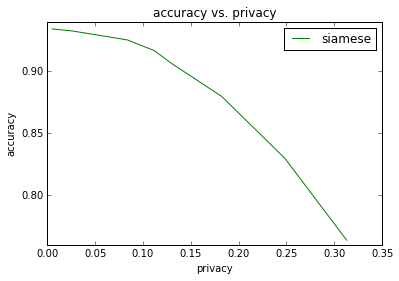

In [19]:
#accs_simple = np.load(save_addr+'simple/accs_test_10.npy')
#privs_simple = np.load(save_addr+'simple/privs_test_10.npy')

#accs_med = np.load('accs_med.npy')
#privs_med = np.load('privs_med.npy')

#accs_large = np.load(save_addr+'siamese/accs_test_10.npy')
#privs_large = np.load(save_addr+'siamese/privs_test_10.npy')

#plt.plot(privs_simple, accs_simple, 'r--', label='simple')
plt.plot(privs, accs, 'g', label='siamese')
#plt.plot(privs_med/500, accs_med, 'b--', label='siamese_2')

plt.legend()
plt.ylabel('accuracy')
plt.xlabel('privacy')
plt.title('accuracy vs. privacy')
plt.show()

accuracy on LFW:

    vgg siamese 4:   94.1
    vgg siamese 2:   93.1
    vgg fine tune:   94.1
    vgg raw:         90.1             
    gil siamese 4:
    gil siamese 2:
    gil fine tune:   87.0
    gil raw:         29.0
    mini raw:

accuracy on Wiki:   

    vgg siamese 4:   92.8
    vgg siamese 2:   93.0
    vgg fine tune:   93.4
    vgg raw:         89.0
    gil siamese 4:
    gil siamese 2:
    gil fine tune:   91.1
    gil raw:         31.4    
    mini raw:


In [ ]:
temp = np.zeros([2,len(noises)])
temp[0,:] = privs*100
temp[1,:] = accs*100

temp = temp.T
temp

In [ ]:
np.savetxt(addr+'privacc/siamese_gender_conv51_rank.txt', temp, delimiter="\t")

In [ ]:
a = np.load(addr+'privacc/accs_test_rank.npy')
b = np.load(addr+'privacc/corrects_test_rank.npy')
print a
print b

In [ ]:
temp = np.zeros([2,len(a)])
temp[0,:] = 1-b
temp[1,:] = a

temp = temp.T
temp

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from __future__ import print_function

def autoenc(features, enc_dim):
    model = Sequential()
    model.add(Dense(enc_dim, activation='sigmoid', input_shape=(features.shape[1],)))
    model.add(Dense(features.shape[1], activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adadelta')
    model.fit(features, features, batch_size=1, nb_epoch=3)
    reconst_features = model.predict(features)
    
    model2 = Sequential()
    model2.add(Dense(enc_dim, activation='sigmoid', input_shape=(features.shape[1],), weights=model.layers[0].get_weights()))
    reduced_features = model2.predict(features)
    
    return reconst_features, reduced_features

In [ ]:
print accs_large
print accs_simple

In [ ]:
print privs_large
print privs_simple

In [ ]:
#newacc = np.zeros(14)
#newpriv = np.zeros(14)

#newacc[0:9] = accs[0:9]
#newacc[9:11] = accs2[0:2]
#newacc[11] = accs[9]
#newacc[12:14] = accs2[2:4]

#newpriv[0:9] = privs[0:9]
#newpriv[9:11] = privs2[0:2]
#newpriv[11] = privs[9]
#newpriv[12:14] = privs2[2:4]

#np.save(save_addr+'accs_all_test', newacc)
#np.save(save_addr+'privs_all_test', newpriv)

In [ ]:
#Training Siamese network in caffe
#solver = caffe.get_solver('gender_siamese_solver_pool5.prototxt')
#solver.net.copy_from('../gender.caffemodel')
#f, l = load_features(solver.net, 'pool5', 20)
#plot_pca(f, l, 2)
#solver.step(1)


In [ ]:
#educational
np.reshape(out[middle_layer_name],(middle_layer_shape[0],-1)) #-1 means infer others automatically
X_reduced[labels == i, 0] # logical indexing

In [ ]:
def test_network(net, middle_layer_name, next_layer_name, num_batch, num_pca, noise_var):
    
    # Loading features from pool5
    features = []
    labels = []
    acc = 0
    
    middle_layer_shape = net.blobs[middle_layer_name].data.shape
    for i in range(0, num_batch):
        out = net.forward(blobs=[middle_layer_name,'label'])
        features.append(copy.copy(np.reshape(out[middle_layer_name],(middle_layer_shape[0],-1) )))
        labels.append(copy.copy(out['label']))
        acc = acc + net.blobs['accuracy_test_top01'].data
    acc = acc / num_batch
    print('Accuracy of test is {:f}'.format(acc))
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    numdata = features.shape[0]
    print('Features are loaded')
    print('Percentage of men is {:f}'.format(np.sum(labels)/labels.shape[0]))
    
    # PCA
    mean_feature = np.mean(features, axis=0)
    normalized_features = features - mean_feature
    pca = decomposition.PCA()
    pca.n_components = num_pca
    pca.fit(normalized_features)
    print('Remained variance is:') 
    print(pca.explained_variance_ratio_) 
    V = pca.components_
    print V.shape
    X_reduced = pca.transform(normalized_features) #it was fit_transform before -> changed to transform
    print('PCA is fitted')
    plt.figure()
    for c, i in zip("rg", [0, 1]):
        plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], c=c)
    plt.title('PCA of features')
    
    # add noise to PCA
    noise = np.random.multivariate_normal(np.zeros([num_pca,]), noise_var*np.eye(num_pca), numdata)
    X_reduced_noisy = X_reduced + noise
    
    # Compute Privacy Measure
    # kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X_reduced_noisy)
    d = np.array([X_reduced,]*numdata) - np.transpose(np.array([X_reduced_noisy,]*numdata),(1,0,2)) #order?
    e = multivariate_normal.pdf(d,np.zeros([num_pca,]), noise_var*np.eye(num_pca))
    r = e/np.max(e,0)
    print("here")
    m = np.sum(r>.95,0)
    ranks = 1 + numdata - rankdata(r,0)
    trueranks = np.diag(ranks)
    res = np.maximum(m,trueranks)
    priv = np.mean(res)
    print('Expected ek-privacy is {:f}'.format(priv))
    
    
    # Reconstruct PCA
    reconstructed = pca.inverse_transform(X_reduced_noisy) 
    recovered = reconstructed + mean_feature    
    reconstructed_pool5_dataset = np.reshape(recovered, (num_batch,)+middle_layer_shape )
    reconstructed_labels = np.reshape(labels, (num_batch,)+(middle_layer_shape[0],) )
    print('Reconstruction is done from PCA projections')
    
    # Computing New Accuracy
    newacc = 0
    for i in range(0, num_batch):
        net.blobs[middle_layer_name].data[...] = reconstructed_pool5_dataset[i,:,:,:,:]
        net.blobs['label'].data[...] = reconstructed_labels[i,:]
        net.forward(start=next_layer_name, end='accuracy_test_top01') # it was fc6 for pool5
        newacc = newacc + net.blobs['accuracy_test_top01'].data
    newacc = newacc / num_batch
    print('Accuracy of test on reconstructed features from PCA is {:f}'.format(newacc))

    return newacc, priv

In [ ]:
features, labels = load_features(net3, "pool5", 100)

In [ ]:
rec_f, red_f = autoenc(features, 2)

In [ ]:
middle_layer_shape = net3.blobs['pool5'].data.shape
num_batch = 100
reconstructed_pool5_dataset = np.reshape(rec_f, (num_batch,)+middle_layer_shape )
reconstructed_labels = np.reshape(labels, (num_batch,)+(middle_layer_shape[0],) )

In [ ]:
np.save('reconstpool',reconstructed_pool5_dataset)
np.save('reconstlabel',reconstructed_labels)

In [ ]:
reconstructed_pool5_dataset = np.load('reconstpool.npy')
reconstructed_labels = np.load('reconstlabel.npy')

In [ ]:
print(reconstructed_labels)

In [ ]:
newacc = 0
for i in range(0, 100):
    net3.blobs['pool5'].data[...] = reconstructed_pool5_dataset[i,:,:,:,:]
    net3.blobs['label'].data[...] = reconstructed_labels[i,:]
    net3.forward(start='fc6', end='accuracy_test_top01') # it was fc6 for pool5
    newacc = newacc + net3.blobs['accuracy_test_top01'].data
print(newacc)
print('Accuracy of test on reconstructed features from PCA is {:f}'.format(newacc))

In [ ]:
#compute relative error
#from numpy import linalg
#fn = linalg.norm(features,axis=1)
#en = linalg.norm(features-predicted,axis=1)
#np.mean(en/fn)

In [ ]:
def test_network(net, middle_layer_name, next_layer_name, num_batch, enc_dim, noise_var ):
    
    # Loading features from pool5
    features = []
    labels = []
    acc = 0
    
    #load features
    features, labels = load_features(net, middle_layer_name, num_batch)

    #dim reduction with ae
    reconst_f, reduced_f = autoenc(features, enc_dim)
    
    # add noise to PCA
    #noise = np.random.multivariate_normal(np.zeros([enc_dim,]), noise_var*np.eye(enc_dim), numdata)
    #X_reduced_noisy = X_reduced + noise
        
    caffe.set_mode_gpu()
    caffe.set_device(1)
    # Compute Privacy Measure
    # kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X_reduced_noisy)
    #d = np.array([X_reduced,]*numdata) - np.transpose(np.array([X_reduced_noisy,]*numdata),(1,0,2)) #order?
    #e = multivariate_normal.pdf(d,np.zeros([enc_dim,]), noise_var*np.eye(enc_dim))
    #r = e/np.max(e,0)
    #print("here")
    #m = np.sum(r>.95,0)
    #ranks = 1 + numdata - rankdata(r,0)
    #trueranks = np.diag(ranks)
    #res = np.maximum(m,trueranks)
    #priv = np.mean(res)
    #print('Expected ek-privacy is {:f}'.format(priv))
    
    
    # Reconstruct back
    #reconstructed = pca.inverse_transform(X_reduced_noisy) 
    #recovered = reconstructed + mean_feature    
    reconstructed_pool5_dataset = np.reshape(reconst_f, (num_batch,)+middle_layer_shape )
    reconstructed_labels = np.reshape(labels, (num_batch,)+(middle_layer_shape[0],) )
    
    # Computing New Accuracy
    newacc = 0
    for i in range(0, num_batch):
        net.blobs[middle_layer_name].data[...] = reconstructed_pool5_dataset[i,:,:,:,:]
        net.blobs['label'].data[...] = reconstructed_labels[i,:]
        net.forward(start=next_layer_name, end='accuracy_test_top01') # it was fc6 for pool5
        newacc = newacc + net.blobs['accuracy_test_top01'].data
    newacc = newacc / num_batch
    print('Accuracy of test on reconstructed features from PCA is {:f}'.format(newacc))



In [ ]:
test_network(net1, middle_layer_name='pool5', next_layer_name='fc6', num_batch=500, enc_dim=2, noise_var=0)

In [ ]:
plt.plot([1,2,3], label="test1")
plt.plot([3,2,1], label="test2")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
features, labels = test_network(net, middle_layer_name='pool5', next_layer_name='fc6', num_batch=50, num_pca=2, noise_var=10)

In [ ]:
import numpy as np
def saveEigenVectors(middle_layer, next_layer, num):
#     pool1 
#     pool2
#     pool3 100
#     pool4 3
#     pool5 2
    address = '/home/ocr/caffe/examples/gender_classification/SiamesePrivacy/'+middle_layer+'_eigen.txt'
    features, labels, V = test_network(net, middle_layer_name= middle_layer, next_layer_name=next_layer, num_batch=50, num_pca=num, noise_var=0)
    np.savetxt(address, V)
#     file = open(address, 'wb+')
#     for i in range(0, len(V)):
#         for j in range(0, len(V[0])): 
            
#             file.write(str(i)+','+str(j)+','+str(V[i][j]) + '\n')
            
#     file.close()
    
saveEigenVectors('pool3', 'conv4_1', 100)    

In [ ]:
features, labels = test_network(net, middle_layer_name='pool5', next_layer_name='fc6', num_batch=50, num_pca=2, noise_var=0)

In [ ]:
# SCRATCH
a = np.array([[1,2,3],[4,5,6]])
b = np.ndarray.flatten(a)
print b
c = a.shape
print c
d = np.reshape(b,c)
print d
print net.blobs['conv1_1'].data.shape
e = (1,)+(2,)
print e[1]
print np.zeros([4,])
print 3*np.eye(4)

In [ ]:
net2 = caffe.Net('gender_siamese_train_pool5.prototxt', '._iter_8495.caffemodel', caffe.TEST)

In [ ]:
def test2(features):
    
    scaler = preprocessing.StandardScaler(with_std=False).fit(features)
    f = scaler.transform(features)
    
    
    pca = decomposition.PCA()
    pca.n_components = 5
    pca.fit(f)
    print('Remained variance is:') 
    print(pca.explained_variance_ratio_) 
    
    X_reduced = pca.fit_transform(f)
    print('PCA is fitted')
    
    plt.figure()
    for c, i in zip("rg", [0, 1]):
        plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], c=c)
    plt.title('PCA of features')
    
    reconstructed=pca.inverse_transform(X_reduced)
    reconstructed_pool5_dataset = np.reshape(reconstructed, (100,10,512,7,7))
    print('reconstruction is done from PCA projections')
    
    newacc = 0
    for i in range(0,100):
        net.blobs['pool5'].data[...] = reconstructed_pool5_dataset[i,:,:,:,:]
        net.forward(start='fc6', end='accuracy_test_top01')
        newacc = newacc + net.blobs['accuracy_test_top01'].data
    newacc = newacc / 100
    print('Accuracy of test on reconstructed features from PCA is {:f}'.format(newacc))


In [ ]:
features = []
labels = []
acc = 0
for i in range(0,100):
    out = net.forward(blobs=['pool5flat','label'])
    features.append(copy.copy(out['pool5flat']))
    labels.append(copy.copy(out['label']))
    acc = acc + net.blobs['accuracy_test_top01'].data

acc = acc/100
print acc
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

In [ ]:
pca = decomposition.PCA()
pca.n_components = 5
pca.fit(features)

In [ ]:
print(pca.explained_variance_ratio_) 

In [ ]:
X_reduced = pca.transform(features)

In [ ]:
plt.figure()
for c, i in zip("rg", [0, 1]):
    plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], c=c)
plt.title('PCA of features')

In [ ]:
#reconstructed = features 
reconstructed=pca.inverse_transform(X_reduced)

In [ ]:
reconstructed_pool5_dataset = np.reshape(reconstructed, (100,10,512,7,7))

In [ ]:
newacc = 0
for i in range(0,100):
    net.blobs['pool5'].data[...] = reconstructed_pool5_dataset[i,:,:,:,:]
    net.forward(start='fc6', end='accuracy_test_top01')
    newacc = newacc + net.blobs['accuracy_test_top01'].data
print newacc / 100

In [ ]:
def ForwardFrom(StartLayer, net, FeatureStartLayer):
    net.blobs[StartLayer].data[...] = FeatureStartLayer
    out=net.forward(start=StartLayer)
    print net.blobs[]
    return net.blobs['accuracy_test_top01'].data

In [ ]:
Gender=ForwardFrom('pool5', net, reconstructed_pool5_dataset[2,:,:,:,:])
Gender

In [ ]:
features.shape[0]

In [ ]:
reconstructed_pool5_dataset[43,:,:,:,:]

In [ ]:
Gender=ForwardFrom('pool5', 'prob', net, reconstructed_pool5_dataset[5,:,:,:,:])
print Gender
print reconstructed_label_dataset[5,:]

In [ ]:
top_k = net.blobs['prob'].data[0].flatten().argsort()

In [ ]:
labels[9]

In [ ]:
print labels[Gender]

In [ ]:
labels[1:11]

In [ ]:
reconstructed[1,:].shape

In [ ]:
features

In [ ]:
features[:,2]

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, n_jobs=-1)
km.fit(X_reduced[:,0:2])
km.predict(X_reduced[:,0:2])
centers = km.cluster_centers_

In [ ]:
plt.plot(centers[:,0],centers[:,1],'.')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure()
for c, i in zip("rg", [0, 1]):
    Axes3D.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], X_reduced[labels == i, 2])

In [ ]:
#net.inputs[0] = images
net.blobs['data'].data = images

In [ ]:
net.params['conv1_2'][0].data

In [ ]:
# creating net for testing (load layers for TEST phase)
#net = caffe.Net('gender_siamese_test.prototxt','._iter_7305.caffemodel', caffe.TEST)

In [ ]:
# reading the data stored in a blob (could be input or output of a layer)
data = net.blobs['data'].data
fc7_activations = net.blobs['fc7'].data

In [ ]:
# setting data for a blob (could be the input of a net)
#myimage = np.array(Image.open('../DataSet/wiki_crop/wiki_crop/00/10049200_1891-09-16_1958.jpg'))
#net.blobs['data'].data[...] = myimage

In [ ]:
# reading weights by using net.params
nice_edge_detectors = net.params['conv1_1']
higher_level_filter = net.params['fc7']

In [ ]:
from google.protobuf import text_format
from caffe.draw import get_pydot_graph
from caffe.proto import caffe_pb2
from IPython.display import display, Image 

_net = caffe_pb2.NetParameter()
f = open("gender_siamese_train_2.prototxt")
text_format.Merge(f.read(), _net)
display(Image(get_pydot_graph(_net,"TB").create_png()))

In [ ]:
# not works
# http://research.beenfrog.com/code/2015/03/28/read-leveldb-lmdb-for-caffe-with-python.html
def get_data_for_case_from_lmdb(lmdb_name, id):
    lmdb_env = lmdb.open(lmdb_name, readonly=True)
    lmdb_txn = lmdb_env.begin()

    raw_datum = lmdb_txn.get(id)
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(raw_datum)

    feature = caffe.io.datum_to_array(datum)
    label = datum.label

    return (label, feature)

In [ ]:
# not works
def read_lmdb(lmdb_file):
    cursor = lmdb.open(lmdb_file, readonly=True).begin().cursor()
    datum = caffe.proto.caffe_pb2.Datum()
    for _, value in cursor:
        datum.ParseFromString(value)
        s = StringIO()
        s.write(datum.data)
        s.seek(0)

        yield np.array(PIL.Image.open(s)), datum.label

In [ ]:
# http://deepdish.io/2015/04/28/creating-lmdb-in-python/
def load_data_into_lmdb(lmdb_name, features, labels=None):
    env = lmdb.open(lmdb_name, map_size=features.nbytes*2)
    
    features = features[:,:,None,None]
    for i in range(features.shape[0]):
        datum = caffe.proto.caffe_pb2.Datum()
        
        datum.channels = features.shape[1]
        datum.height = 1
        datum.width = 1
        
        if features.dtype == np.int:
            datum.data = features[i].tostring()
        if features.dtype == np.float: 
            datum.float_data.extend(features[i].flat)
        else:
            raise Exception("features.dtype unknown.")
        
        if labels is not None:
            datum.label = int(labels[i])
        
        str_id = '{:08}'.format(i)
        with env.begin(write=True) as txn:
            txn.put(str_id, datum.SerializeToString())
            
load_data_into_lmdb("pool5_lmdb", features.astype(float), labels)
#load_data_into_lmdb("/home/ubuntu/data/test_data_lmdb", features_testing, labels_testing)

In [ ]:
# reading lmdb file -> correct
for key, value in lmdb_cursor:
    print value
    datum.ParseFromString(value)

    label = datum.label
    data = caffe.io.datum_to_array(datum)
    im = data.astype(np.uint8)
    im = np.transpose(im, (2, 1, 0)) # original (dim, col, row)
    print "label ", label

    plt.imshow(im)
    plt.show()


In [ ]:
# need for the below section
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [ ]:
# reading lmdb file -> correct -> no need to use this now
from itertools import islice
lmdb_file = "../DataSet/wiki_crop/wiki_crop/test2_lmdb"
lmdb_env = lmdb.open(lmdb_file)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe_pb2.Datum()
n=10
images = [None]*n
labels = [None]*n
n_item = take(n, lmdb_cursor)
for i in range(0,n): 
    datum.ParseFromString(n_item[i][1])
    labels[i] = datum.label
    print(n_item[i][0])
    im = caffe.io.datum_to_array(datum).astype(np.uint8)
    im = np.transpose(im, (2, 1, 0)) 
    im = im[16:240,16:240,:]
    images[i] = im
    
    plt.imshow(images[i])
    plt.show()
images = np.asarray(images)
#images.shape

In [ ]:
def mycrop(im, new_width, new_height):
    width, height = im.size   
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    im.crop((left, top, right, bottom))
    return im

In [ ]:
from scipy.stats import norm
from scipy.stats.mstats import rankdata
a = np.array([[1,2,3,4,5,6]])
var = 1
n = np.random.normal(0,var,6)
b = a + n
d = np.tile(b,(6,1)) - np.tile(np.transpose(a),(1,6))
e = norm.pdf(d,loc=0,scale=var)
np.max(e,0)
r = e/np.max(e,0)
print r>0.5
m = np.sum(r>.9,0)
ranks = 7 - rankdata(r,0)
trueranks = np.diag(ranks)
res = np.maximum(m,trueranks)
print np.mean(res)

In [ ]:
a = np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])
print a.shape
a

In [ ]:
b = np.array([a,]*5)
print b.shape
print b
print np.transpose(b,(1,0,2))

In [ ]:
print a.T
c = np.array([a.T,]*5)
np.reshape(c,(5,5,2))

In [ ]:
a = np.zeros(3)
a[2]

In [ ]:
b

In [ ]:
a = np.array([[1,2],[3,4],[5,6]])
b = np.array([[3,4],[1.5,3],[5.1,6.1]])
print a
print b

In [ ]:
np.array([a,]*3)

In [ ]:
np.transpose(np.array([b,]*3),(1,0,2))

In [ ]:
c = (np.array([a,]*3) - np.transpose(np.array([b,]*3),(1,0,2)))
print c
print c.shape

In [ ]:
d = multivariate_normal.pdf(c,np.zeros([2,]), 1*np.eye(2))
print d
e = d.T
print e

In [ ]:
multivariate_normal.pdf([-4.1,-4.1],np.zeros([2,]), 1*np.eye(2))

In [ ]:
import matplotlib.mlab

data=np.array(
    [(5,np.array([1,2])),
     (3,np.array([1,3])),
     (3,np.array([1,4])),
     (5,np.array([1,5])),
     (1,np.array([1,6]))],
    dtype=[('a', np.uint32), ('income', np.ndarray)])

result=matplotlib.mlab.rec_groupby(data, ('a',), (('income',np.mean,'avg_income'),))
print result

In [ ]:
z = np.zeros([3,np.max(label)+1])
k = np.zeros(np.max(label)+1)
for i in range(3):
    z[label[i],:] = z[label[i],:] + e[i,:]
    k[label[i]] = k[label[i]] + 1
print z
print (z.T/k).T
print k

In [ ]:
e

In [ ]:
label = np.array([1,2,1])
np.concatenate(a,label)

In [ ]:
print e
f = e/np.max(e,0)
print f

In [ ]:
g = np.sum(f>.8,0)
g

In [ ]:
ranks = 1 + 3 - rankdata(f,0)
ranks

In [ ]:
trueranks = np.diag(ranks)
trueranks

In [ ]:
res = np.maximum(m,trueranks)

In [14]:
a = 2
print(a!=2)

False
